<a href="https://colab.research.google.com/github/ali-unlu/Travel-Customer-Churn-with-Oversampling/blob/main/Travel_Customer_Churn_with_Oversampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction 

The aim of this post is to  identify and visualize factors that contribute to customer churn of a travel company.  After EDA analysis, I will build prediction models to find:

1. Classify if a customer is going to churn or not  
2. Choose a model that will attach a probability to the churn to make it easier for customer service to target to prevent churn

I did a similar analysis before by creating a simple logistic regression analysis but know I want to apply more comprehensive method. [Previously I analyzed bank customer data](https://github.com/ali-unlu/bank-customer-churn-analysis/blob/main/Bank_Customer_Churn.ipynb) and I looked for different data that I found this data on Kaggle. It was about the tour & travel company data that was realesed in 2018. More informatio about the data can be found [here.](https://www.kaggle.com/bayunova/tour-travels-customer-churn/data)

# Data 

I am using google colab ptaform so, the initial codes for mounting google drive to the colab platform.





In [1]:
from google.colab import drive
drive.mount('/content/drive')
# set the folder
import sys
sys.path.append('/content/drive/MyDrive/Python/IBM Machine Learning/Classification/Assigment')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 
warnings.filterwarnings("ignore", category=UserWarning) 

In [1]:
#pip install catboost # Google delete 

In [29]:
# loading necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression  
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.svm import SVC
from catboost import CatBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import accuracy_score,recall_score
from xgboost import XGBClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, GridSearchCV

In [5]:
# Data loading and initial checks
filepath = '/content/drive/MyDrive/Python/IBM Machine Learning/Classification/Assignment/Customertravel.csv'
data = pd.read_csv(filepath, sep=',')

First I will check the dimension and types of the data

In [6]:
data.shape

(954, 7)

In [7]:
data.dtypes

Age                            int64
FrequentFlyer                 object
AnnualIncomeClass             object
ServicesOpted                  int64
AccountSyncedToSocialMedia    object
BookedHotelOrNot              object
Target                         int64
dtype: object

Data has 7 variables, four of them are objects and our target variable is __Target__, which points out the churn status of the customer. Here is the first rows of the variables. 

In [8]:
data.head().T

,0,1,2,3,4
Age,34,34,37,30,30
FrequentFlyer,No,Yes,No,No,No
AnnualIncomeClass,Middle Income,Low Income,Middle Income,Middle Income,Low Income
ServicesOpted,6,5,3,2,1
AccountSyncedToSocialMedia,No,Yes,Yes,No,No
BookedHotelOrNot,Yes,No,No,No,No
Target,0,1,0,0,0


In [9]:
data.describe()

,Age,ServicesOpted,Target
count,954.000000,954.000000,954.000000
mean,32.109015,2.437107,0.234801
std,3.337388,1.606233,0.424097
min,27.000000,1.000000,0.000000
25%,30.000000,1.000000,0.000000
50%,31.000000,2.000000,0.000000
75%,35.000000,4.000000,0.000000
max,38.000000,6.000000,1.000000


Variable types seems to be in right format.  
 __Missing values:__ It is very good that the data has no missing variable, which is very unusual in normal situation. 

# EDA 
First, we can start with the target variable and we need to check whether it is a balanced variable. Results show that it is not a balanced output, the ratio is 23% - 77%, so we can also test different resampling methods to balance the distribution of our target variable. Since the sample size is small, it is a better strategy to implement upsampling. We can also compare how the results vary in different resampling strategy. 

In [10]:
Target = 'Target'
data[Target].value_counts(normalize = 'True')

0    0.765199
1    0.234801
Name: Target, dtype: float64

### Dividing variables in different categories. 

I find easier to analyze data when I divided them into categories. I calculate how many unique values of features have and then assign them to subcategories.  Binary variables need to be only two unique variables. I consider variable categoric if it has more than 2 and less than 6 unique values. This is not a golden rule of course, it may change depending on the dataset. 

In [11]:
data_uniques = pd.DataFrame([[i, len(data[i].unique())] for i in data.columns], columns=['Variable', 'Unique Values']).set_index('Variable')
data_uniques

,Unique Values
Variable,
Age,11
FrequentFlyer,3
AnnualIncomeClass,3
ServicesOpted,6
AccountSyncedToSocialMedia,2
BookedHotelOrNot,2
Target,2


In [12]:
binary_variables = list(data_uniques[data_uniques['Unique Values'] == 2].index) 
binary_variables


['AccountSyncedToSocialMedia', 'BookedHotelOrNot', 'Target']

Two features, 1- Account has a social media, 2- Booked Hotel are binary variables.  

In [13]:
# Categorical variables
categorical_variables = list(data_uniques[(6 >= data_uniques['Unique Values']) & (data_uniques['Unique Values'] > 2)].index)
categorical_variables

['FrequentFlyer', 'AnnualIncomeClass', 'ServicesOpted']

In [14]:
# numeric variables
numeric_variables = list(set(data.columns) - set(categorical_variables) - set(binary_variables))
numeric_variables

['Age']

# EDA Graphs

First, I will check their distribution and later I will compare the target variable distibution in dependent variables. *italicized text*

In [110]:
def category(variable):
    print(data[variable].value_counts())
    
    sns.countplot(data[variable])
    plt.show()

No           608
Yes          286
No Record     60
Name: FrequentFlyer, dtype: int64


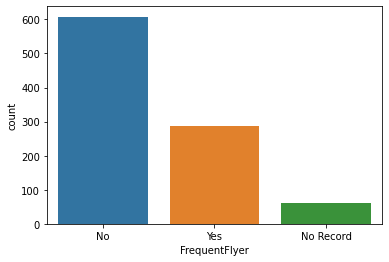

Middle Income    409
Low Income       386
High Income      159
Name: AnnualIncomeClass, dtype: int64


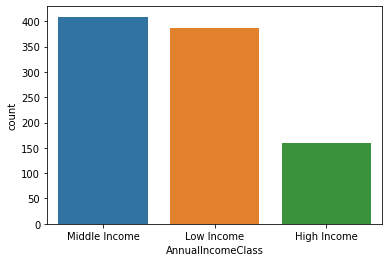

1    404
2    176
3    124
4    117
5     69
6     64
Name: ServicesOpted, dtype: int64


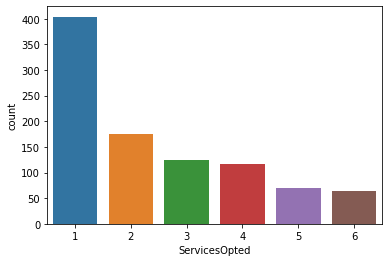

In [111]:
for i in categorical_variables:
    category(i)

- Most of the company customers are middle class and followed by low income groups.
- A liner decreas in service opted category
- Majority of the cusmoter in no frequent flyer group

No     594
Yes    360
Name: AccountSyncedToSocialMedia, dtype: int64


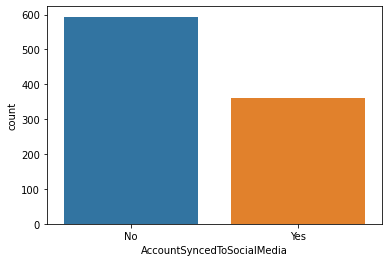

No     576
Yes    378
Name: BookedHotelOrNot, dtype: int64


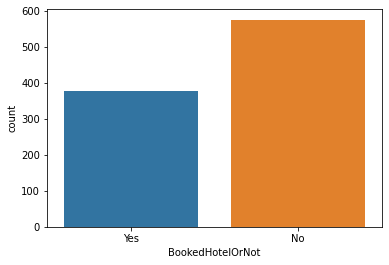

0    730
1    224
Name: Target, dtype: int64


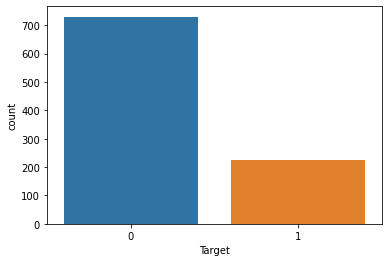

In [112]:
for i in binary_variables:
    category(i)

- Most the customers have no social media accounts
- Most of the customer have no hotel reservation 
- As mentioned above, around 23% of the customers churn

In [113]:
def numeric(variable):
    
    plt.hist(data[variable], bins = 20, color = "blue")
    plt.xlabel(variable)
    plt.ylabel("Frequency")
    plt.title("{} variable distribution".format(variable))
    plt.show()

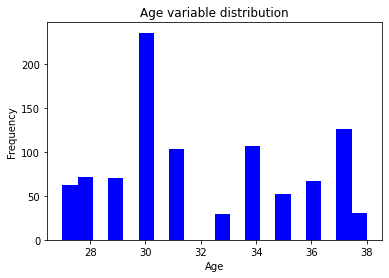

In [114]:
for i in numeric_variables:
    numeric(i)

- Company serves to spesific age groups, customers age range frm 25 to 40. 

### Target variable vs categoric and binary variables

In [121]:
def target_vs_categoric(variable):
    
    print("{} effect of variable on customer churn : \n".format(variable))
    print(data.groupby(variable)[Target].mean())
    
    sns.countplot(y = variable, hue = Target , data = data)
    plt.show()

FrequentFlyer effect of variable on customer churn : 

FrequentFlyer
No           0.113487
No Record    0.133333
Yes          0.513986
Name: Target, dtype: float64


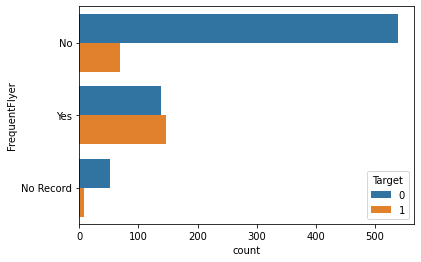

AnnualIncomeClass effect of variable on customer churn : 

AnnualIncomeClass
High Income      0.578616
Low Income       0.269430
Middle Income    0.068460
Name: Target, dtype: float64


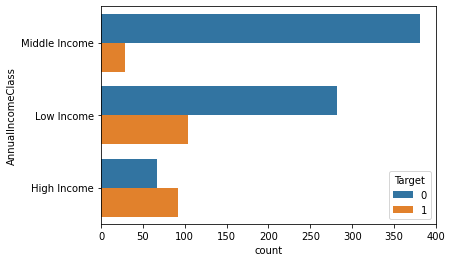

ServicesOpted effect of variable on customer churn : 

ServicesOpted
1    0.230198
2    0.295455
3    0.080645
4    0.188034
5    0.376812
6    0.328125
Name: Target, dtype: float64


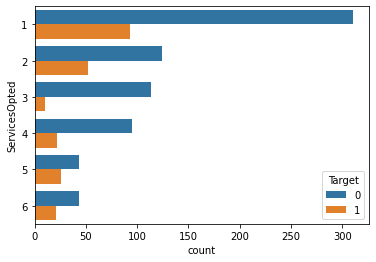

In [122]:
for i in categorical_variables:
    target_vs_categoric(i)

## Summary of categorical variables
- Having a freqent flyer has more customer churn rate compared to other groups
- The company loses most of the customers from the high income group, following by the middle income group. 
- Service opted results show that groups belonging to 5 and 6 have more churn rate, even half of the customers in these groups churn.  

AccountSyncedToSocialMedia effect of variable on customer churn : 

AccountSyncedToSocialMedia
No     0.210438
Yes    0.275000
Name: Target, dtype: float64


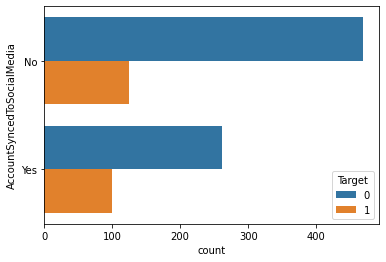

BookedHotelOrNot effect of variable on customer churn : 

BookedHotelOrNot
No     0.305556
Yes    0.126984
Name: Target, dtype: float64


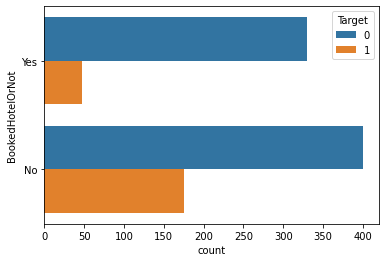

Target effect of variable on customer churn : 

Target
0    0
1    1
Name: Target, dtype: int64


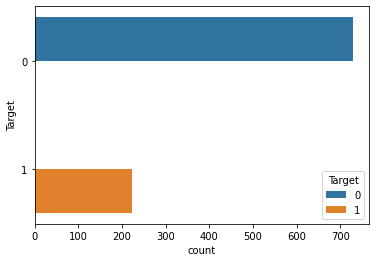

In [123]:
for i in binary_variables:
    target_vs_categoric(i)

### Summary of Binary variables

- Customers who have a social media account have a higher rates of churn.
- Customers who do not book a hotel has a higher rates of churn.

In [124]:
def outlier_show(variable):
    
    sns.boxplot(data[variable])
    plt.show()

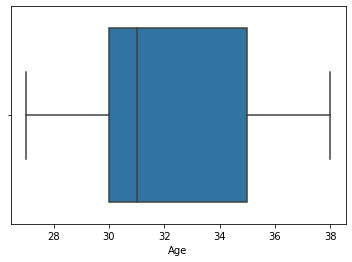

In [125]:
for i in numeric_variables:
    outlier_show(i)

### detecting outliers

We have actually no outliers seen in age boxplot above but for the different senario, you can also use these codes to detect outliers and remove from the dataset. 

In [126]:
 def outlier(df, variable_list):
    from collections import Counter
    outlier_indexes = []
    
    for i in variable_list:
        
        Q1 = df[i].quantile(0.25)
        Q3 = df[i].quantile(0.75)


        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5*IQR
        upper_bound = Q3 + 1.5*IQR

        total_filter = ((df[i] < lower_bound) | (df[i] > upper_bound))

        outlier_observation = df[i][total_filter]
        outlier_index = outlier_observation.index
        
        outlier_indexes.extend(outlier_index)
        
    outlier_indexes = Counter(outlier_indexes)
    
    common_index = [i for i, v in outlier_indexes.items() if v > 0]
    
    return common_index

In [127]:
outlier_rows = outlier(data, numeric_variables)

In [128]:
data.loc[outlier_rows]

,Age,FrequentFlyer,AnnualIncomeClass,ServicesOpted,AccountSyncedToSocialMedia,BookedHotelOrNot,Target


In [129]:
data = data.drop(outlier_rows, axis = 0).reset_index(drop = True)

In [130]:
data.shape

(954, 7)

### Correlation matrix
There is no multicollanarity issue with our data set.

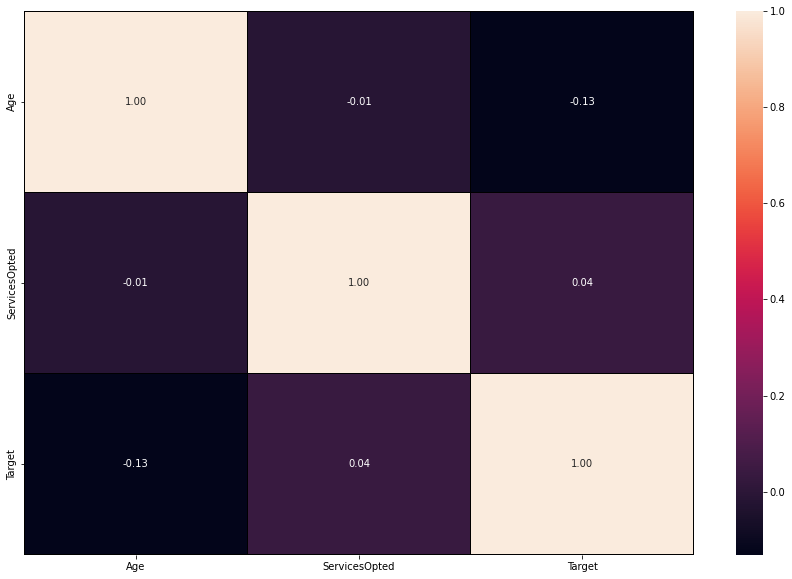

In [131]:
fig, ax = plt.subplots(figsize=(15,10)) 
sns.heatmap(data.corr(), annot = True, linecolor = "black", lw = 0.5, fmt= '.2f') 


# Data Processing

 I converted binary and categorical features into dummy variables with pandas function. 

In [15]:
data = pd.get_dummies(data, columns = binary_variables[0:2], drop_first=True) # kept target variable out of the dummy processing
data= pd.get_dummies(data, columns= categorical_variables, drop_first=True)
data.head().T

,0,1,2,3,4
Age,34,34,37,30,30
Target,0,1,0,0,0
AccountSyncedToSocialMedia_Yes,0,1,1,0,0
BookedHotelOrNot_Yes,1,0,0,0,0
FrequentFlyer_No Record,0,0,0,0,0
FrequentFlyer_Yes,0,1,0,0,0
AnnualIncomeClass_Low Income,0,1,0,0,1
AnnualIncomeClass_Middle Income,1,0,1,1,0
ServicesOpted_2,0,0,0,1,0
ServicesOpted_3,0,0,1,0,0


To make the all features in the same scale, I also scales the numeric variables. 

In [16]:
from sklearn.preprocessing import MinMaxScaler 
mm = MinMaxScaler()

In [17]:
for column in [ numeric_variables]: 
    data[column] = mm.fit_transform(data[column])

In [18]:
round(data.describe().T, 3)

,count,mean,std,min,25%,50%,75%,max
Age,954.0,0.464,0.303,0.0,0.273,0.364,0.727,1.0
Target,954.0,0.235,0.424,0.0,0.000,0.000,0.000,1.0
AccountSyncedToSocialMedia_Yes,954.0,0.377,0.485,0.0,0.000,0.000,1.000,1.0
BookedHotelOrNot_Yes,954.0,0.396,0.489,0.0,0.000,0.000,1.000,1.0
FrequentFlyer_No Record,954.0,0.063,0.243,0.0,0.000,0.000,0.000,1.0
FrequentFlyer_Yes,954.0,0.300,0.458,0.0,0.000,0.000,1.000,1.0
AnnualIncomeClass_Low Income,954.0,0.405,0.491,0.0,0.000,0.000,1.000,1.0
AnnualIncomeClass_Middle Income,954.0,0.429,0.495,0.0,0.000,0.000,1.000,1.0
ServicesOpted_2,954.0,0.184,0.388,0.0,0.000,0.000,0.000,1.0
ServicesOpted_3,954.0,0.130,0.336,0.0,0.000,0.000,0.000,1.0


### Strafication of data split
Since our target variable is not balanced, I use stratified sampling method to protect the original distribution rate.

In [38]:
from sklearn.model_selection import StratifiedShuffleSplit

target = 'Target'

feature_cols = [x for x in data.columns if x != target]

# Split the data into two parts with 1500 points in the test data
# This creates a generator
strat_shuff_split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)

# Get the index values from the generator
train_idx, test_idx = next(strat_shuff_split.split(data[feature_cols], data[target]))

# Create the data sets
X_train = data.loc[train_idx, feature_cols]
y_train = data.loc[train_idx, target]

X_test = data.loc[test_idx, feature_cols]
y_test = data.loc[test_idx, target]

In [39]:
y_train.value_counts(normalize=True)

0    0.764618
1    0.235382
Name: Target, dtype: float64

In [40]:
y_test.value_counts(normalize=True)


0    0.766551
1    0.233449
Name: Target, dtype: float64

## Oversampling with SMOTE

Keep in mind that, it needs to be done after data split. 



In [25]:
# Because the Target is imbalance, i try to balance the data with SMOTE(OverSampling)
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=46)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
#X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

In [26]:
print(f"Before resample : \n{y_train.value_counts()} \nAfter resample : \n{y_train_res.value_counts()}")

Before resample : 
0    510
1    157
Name: Target, dtype: int64 
After resample : 
1    510
0    510
Name: Target, dtype: int64


# Model Building with Cross Validation

I will use the main classification models under the hood of sklearn. I will first analyze based on original data set and then apply the same methods on new data set. 

In [41]:
# Models for Classification with SMOTE
models = [('LR', LogisticRegression(random_state=42)),
          ('KNN', KNeighborsClassifier()),
          ('CART', DecisionTreeClassifier(random_state=42)),
          ('RF', RandomForestClassifier(random_state=42)),
          ('SVR', SVC(gamma='auto',random_state=42)),
          ('GB', GradientBoostingClassifier(random_state = 42)),
          ("LightGBM", LGBMClassifier(random_state=42)),
          ("Adaboost", AdaBoostClassifier(random_state= 42)),
          ("Gradient Boosting", GradientBoostingClassifier(random_state=42))]


In [42]:
# original data
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=10, random_state=42, shuffle=True)
    cv_results = cross_val_score(model, data[feature_cols], data[target], cv=kfold)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
 

LR: 0.832270 (0.036705)
KNN: 0.873136 (0.032114)
CART: 0.891974 (0.025088)
RF: 0.884649 (0.034969)
SVR: 0.839605 (0.024936)
GB: 0.887752 (0.039226)
LightGBM: 0.875197 (0.037558)
Adaboost: 0.827061 (0.022016)
Gradient Boosting: 0.887752 (0.039226)


In [31]:
# oversampled data
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=10, random_state=42, shuffle=True)
    cv_results = cross_val_score(model, X_train_res, y_train_res, cv=kfold)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
 

LR: 0.809804 (0.023692)
KNN: 0.871569 (0.026471)
CART: 0.891176 (0.027187)
RF: 0.891176 (0.018315)
SVR: 0.833333 (0.023200)
GB: 0.915686 (0.022442)
LightGBM: 0.903922 (0.018498)
Adaboost: 0.863725 (0.021232)
Gradient Boosting: 0.915686 (0.022442)


# Model selection

- __Base Model:__ Our results show that Adaboost performs better here, following by SVR and CART.
- __SMOTE Model:__ When we resample our target variable, Random Forest performed well followed by lightGBM (slightly lower than RF) and Adaboost.  

- To give an idea, I pulled the RF results here but I will tune the parameters to produce better and balanced results below.

In [44]:
# RF Confusion Matrix
model_RF = RandomForestClassifier(random_state=42)
model_RF.fit(X_train_res, y_train_res)


RandomForestClassifier(random_state=42)

In [47]:
# Classification Report 
print(classification_report(model_RF.predict(X_test), y_test))

              precision    recall  f1-score   support

           0       0.92      0.94      0.93       216
           1       0.79      0.75      0.77        71

    accuracy                           0.89       287
   macro avg       0.85      0.84      0.85       287
weighted avg       0.89      0.89      0.89       287



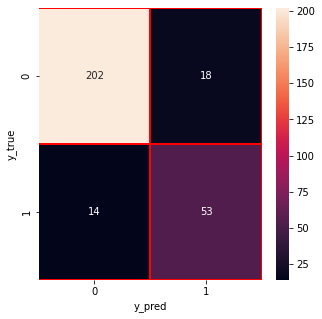

In [48]:
y_pred = model_RF.predict(X_test)
y_true = y_test

cm =confusion_matrix(y_true,y_pred)

f, ax = plt.subplots(figsize = (5,5))
sns.heatmap(cm,annot=True,linewidths=0.5,linecolor="red",fmt = ".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [49]:
# Auc Roc Curve
def generate_auc_roc_curve(clf, X_test):
    y_pred_proba = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test,  y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr,tpr,label="AUC ROC Curve with Area Under the curve ="+str(auc))
    plt.legend(loc=4)
    plt.show()
    pass

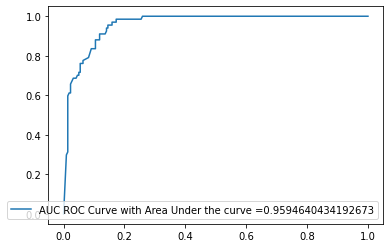

In [50]:
generate_auc_roc_curve(model_RF, X_test)


# Tuning

I will compare two models here: Light GBM and Random Forest. 


## Light GBM

In [51]:
# LightGBM: 
lgb_model = LGBMClassifier()
# Model Tuning
lgbm_params = {'colsample_bytree': 0.5,
 'learning_rate': 0.01,
 'max_depth': 6,
 'n_estimators': 500}

lgbm_tuned = LGBMClassifier(**lgbm_params).fit(data[feature_cols], data[target])


In [55]:
# Classification Report 
print(classification_report(lgbm_tuned.predict(X_test),y_test))

              precision    recall  f1-score   support

           0       0.97      0.92      0.94       232
           1       0.72      0.87      0.79        55

    accuracy                           0.91       287
   macro avg       0.84      0.90      0.86       287
weighted avg       0.92      0.91      0.91       287



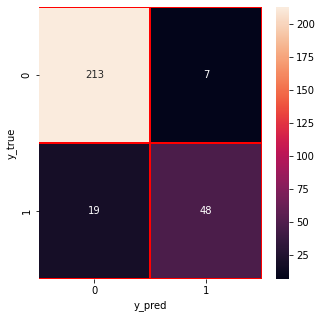

In [60]:
y_pred = lgbm_tuned.predict(X_test)
y_true = y_test

cm =confusion_matrix(y_true,y_pred)

f, ax = plt.subplots(figsize = (5,5))
sns.heatmap(cm,annot=True,linewidths=0.5,linecolor="red",fmt = ".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

## Random Forest 

In [53]:
# random forest
rf_params = {"max_depth": [2,5,8,10],
            "max_features": [2,5,8],
            "n_estimators": [10,500,1000],
            "min_samples_split": [2,5,10]}
rf_model = RandomForestClassifier()

rf_cv_model = GridSearchCV(rf_model, 
                           rf_params, 
                           cv = 10, 
                           n_jobs = -1, 
                           verbose = 2) 
rf_cv_model.fit(X_train_res, y_train_res)
print("The best parameters: " + str(rf_cv_model.best_params_))


Fitting 10 folds for each of 108 candidates, totalling 1080 fits
The best parameters: {'max_depth': 8, 'max_features': 8, 'min_samples_split': 10, 'n_estimators': 1000}


In [57]:
rf_tuned = RandomForestClassifier(max_depth = 8, 
                                  max_features = 8, 
                                  min_samples_split = 10,
                                  n_estimators = 1000)

rf_tuned.fit(X_train_res, y_train_res)

RandomForestClassifier(max_depth=8, max_features=8, min_samples_split=10,
                       n_estimators=1000)

In [58]:
# Classification Report 
print(classification_report(rf_tuned.predict(X_test),y_test))

              precision    recall  f1-score   support

           0       0.90      0.96      0.92       206
           1       0.87      0.72      0.78        81

    accuracy                           0.89       287
   macro avg       0.88      0.84      0.85       287
weighted avg       0.89      0.89      0.89       287



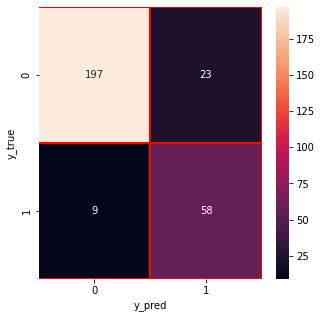

In [59]:
y_pred = rf_tuned.predict(X_test)
y_true = y_test

cm =confusion_matrix(y_true,y_pred)

f, ax = plt.subplots(figsize = (5,5))
sns.heatmap(cm,annot=True,linewidths=0.5,linecolor="red",fmt = ".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

## Model comparison

In this stage, we can use cross validation again to reduce the overfitting. After re-fitting the models, I will illustrate the variable importance and ROC graphs for each models. 

In [61]:
# evaluate each model in turn
models = [("LightGBM", lgbm_tuned),
          ('Random Forest', rf_tuned)]
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=10, random_state=42, shuffle=True)
    cv_results = cross_val_score(model,data[feature_cols], data[target], cv=10, scoring="accuracy")
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LightGBM: 0.887774 (0.024266)
Random Forest: 0.901414 (0.020828)


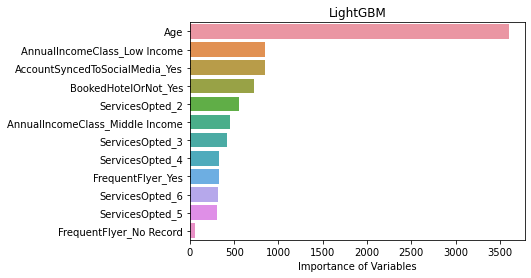

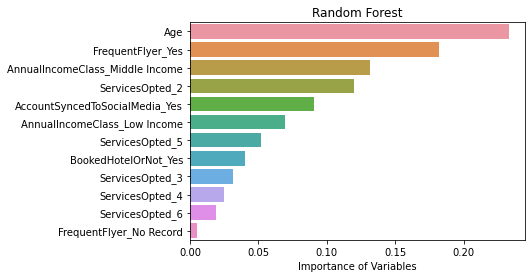

In [62]:
for name, model in models:
        base = model.fit(X_train_res,y_train_res)
        y_pred = base.predict(X_test)
        acc_score = accuracy_score(y_test, y_pred)
        feature_imp = pd.Series(base.feature_importances_,
                        index=data[feature_cols].columns).sort_values(ascending=False)

        sns.barplot(x=feature_imp, y=feature_imp.index)
        plt.xlabel('Importance of Variables')
        plt.ylabel('')
        plt.title(name)
        plt.show()

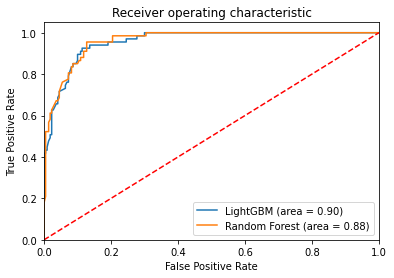

In [66]:
first_roc_auc = roc_auc_score(y_test, lgbm_tuned.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, lgbm_tuned.predict_proba(X_test)[:,1])


second_roc_auc = roc_auc_score(y_test, rf_tuned.predict(X_test))
second_fpr, second_tpr, second_thresholds = roc_curve(y_test, rf_tuned.predict_proba(X_test)[:,1])

plt.figure()

plt.plot(fpr, tpr, label='LightGBM (area = %0.2f)' % first_roc_auc)
plt.plot(second_fpr, second_tpr, label='Random Forest (area = %0.2f)' % second_roc_auc)


plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

# Summary
- We tested two different data types, one with original, one with SMOTE resampling strategy. While there is no significant improvement seen on acuracy rate, the error rate between train and test set reduces. 

- While in Base Model Adaboost performs better, on SMOTE Model, Random Forest performed well. So, ensemble models works well with this data and there is only small difference between calculation methods.

- The age is the most important variable in data set in each model but the order of feature importance varies according to the model.

- Our both models have pretty good ROC results and accurary rates but RF performs well on precision score, which will be more important to focus on churn rate. 

### Thanks for visit and reading. Please feel free to share your comments and suggestions to improve the model. 

Ali Unlu 